 # ***Data Preprocessing***

#### **Students**
André Silva, r20191226@novaims.unl.pt
Corssino Tchavana, 20220597@novaims.unl.pt
Diogo Silva, 20221393@novaims.unl.pt
Lucas Ferreira, 20220621@novaims.unl.pt

#### **Data Source**
Data Source:
https://www.kaggle.com/datasets/alessiocorrado99/animals10?select=raw-img

#### **Summary**

In the beginning of this notebook the images considered as Noisy, Blurry, the ones that are not RGB, not JPEG and that have a border are eliminated from the dataset, since it would decrease the model performance.

Then the group conducted an analysis of outliers using Isolation Forest, Z-Score and the group conducted once again PCA but now with the more narrow dataset since some images were deleted. At the end of this study more images were deleted from the dataset.

After that it was made the Train/Test split for the models training and tests for the future, keeping 350 images in the test folder.

The final part of this notebook is the realization of Data Augmentation to make the dataset balanced.

To conclude at the end of this notebook our dataset is divided in 3 main folders:
- train with 43860 instances, 4386 in each class 
- test with 3500 instances, 350 in each folder.



# **Load Dataset**

### **Import**

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

import cv2
from sklearn.utils import shuffle
from google.colab import drive
from tqdm import tqdm

import os
import time
import shutil
import random 
import zipfile
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import cv2
from google.colab import drive, files
from google.colab.patches import cv2_imshow

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow.keras import datasets, Sequential, layers, initializers, regularizers, optimizers, metrics 
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn import svm, decomposition
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.utils import shuffle

from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from PIL import Image
import os
import cv2
import os
import random
import shutil
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from google.colab import files
import os
from PIL import Image

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/"
main_folder, training_folder = "10_animals.zip/", "train"
# If using Google Drive
if gdrive:
    # Setup drive
    drive.mount('/content/drive', force_remount=True)        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + '10_animals.zip', '10_animals.zip')
    # Extract files
    zip_ = zipfile.ZipFile('10_animals.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 19.270 seconds


# **Delete bad quality images**

In this section the images that have Borders, are not JPEG nor RGB and were labeled as Blurry or Noise will be eliminated from the dataset - the analysis was done in the explore notebook. If in these processes the output is different from the one in the explore notebook it is because the image was removed in the previous removal functions.

The images are resized to (140, 100) to try and perserve the aspect ratio of the original images as much as possible.

The following code is a repeat of the code in the explore notebook, but instead of counting the images that meet certain standards it removes them from the dataset.

### **Borders**

In [ ]:
# Set the main folder path
main_folder = path + training_folder

# Set the border threshold
border_thresh = 10

# Loop through the subfolders inside the main folder
for subfolder in os.listdir(main_folder):
    # Get the full path of the subfolder
    subfolder_path = os.path.join(main_folder, subfolder)
    # Loop through the images inside the subfolder
    for filename in os.listdir(subfolder_path):
        # Get the full path of the image
        img_path = os.path.join(subfolder_path, filename)
        # Load the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Resize the image to (200, 150)
        img = cv2.resize(img, (200, 150))
        # Get the height and width of the image
        h, w = img.shape[:2]
        # Check if any border is black
        top_border = np.mean(img[0:border_thresh, :]) == 0
        bottom_border = np.mean(img[h-border_thresh:h, :]) == 0
        left_border = np.mean(img[:, 0:border_thresh]) == 0
        right_border = np.mean(img[:, w-border_thresh:w]) == 0
        if top_border or bottom_border or left_border or right_border:
            #print(f"Image {img_path} has a border.")
            # Delete the image
            os.remove(img_path)


### **Not JPEG**

In [ ]:
path_to_dataset= path + training_folder

exceptions = 0

# loop through each category folder
for folder in os.listdir(path_to_dataset):
    # loop through each file in the folder
    for file_name in os.listdir(os.path.join(path_to_dataset, folder)):
        # check the file extensions
        extension = os.path.splitext(file_name)[1]
        if extension.lower() != '.jpg' and extension.lower() != '.jpeg':
            exceptions += 1
            # delete the image
            os.remove(os.path.join(path_to_dataset, folder, file_name))
            
print(f"Number of files that are not JPEG: {exceptions}")


Number of files that are not JPEG: 14


### **Not RGB**

In [ ]:

# loop through each category folder
for folder in os.listdir(path_to_dataset):
    # create counters for different image modes
    num_rgb_images = 0
    num_grayscale_images = 0
    num_other_images = 0
    
    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # open the image
        img = Image.open(os.path.join(path_to_dataset, folder, file))
        
        # check the image mode
        if img.mode == 'RGB':
            num_rgb_images += 1
        elif img.mode == 'L':
            num_grayscale_images += 1
        else:
            num_other_images += 1
            # if the image is not RGB, delete it
            image_path = os.path.join(path_to_dataset, folder, file)
            os.remove(image_path)

### **Blurry Images**

In [ ]:
# loop through each category folder
for folder in os.listdir(path_to_dataset):
    # create an empty list to store the file names
    file_names = []
    
    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # check if the file is a JPEG or JPG image
        if file.lower().endswith(('jpeg', 'jpg')):
            # add the file name to the list
            file_names.append(file)
        
    # calculate the sharpness of each image using Laplacian filter
    for file_name in file_names:
        # read the image
        img = cv2.imread(os.path.join(path_to_dataset, folder, file_name))
        
        # resize the image to (140, 100)
        img = cv2.resize(img, (140, 100))
        
        # convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # calculate the Laplacian variance as a measure of image sharpness
        lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # set a threshold value for the variance below which the image is considered blurry
        threshold = 550
        
        # check if the image is blurry or not
        if lap_var < threshold:
            # delete the image
            os.remove(os.path.join(path_to_dataset, folder, file_name))


### **Noise Images**

In [ ]:
# Set the main folder path
path_to_dataset = path + training_folder

# create an empty list to store the noisy file names and their mean amplitudes
noisy_files = []

# loop through each category folder
for folder in os.listdir(path_to_dataset):
    # create an empty list to store the file names
    file_names = []
    
    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # check if the file is a JPEG image and has three color channels
        if file.endswith('.jpeg') or file.endswith('.jpg'):
            file_path = os.path.join(path_to_dataset, folder, file)
            img = cv2.imread(file_path)
            if img is not None and img.shape[2] == 3:
                # resize the image to (140, 100)
                img = cv2.resize(img, (140, 100))
                # add the file name and image to the list and set
                file_names.append((file_path, img))
    
    # calculate the noise level of each image using Fast Fourier Transform
    for file_name, img in file_names:
        # convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # apply a Fast Fourier Transform to the image
        f = np.fft.fft2(gray)
        fshift = np.fft.fftshift(f)
        
        # calculate the amplitude spectrum of the Fourier Transform
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        
        # set a threshold value for the mean amplitude below which the image is considered noisy
        threshold = 129
        
        # calculate the mean amplitude of the Fourier Transform
        mean_amplitude = np.mean(magnitude_spectrum)
        
        # check if the image is noisy or not
        if mean_amplitude < threshold:
            img_path = os.path.join(path_to_dataset, file_name)
            # delete the image
            if os.path.exists(img_path):
                os.remove(img_path)
            else:
                v=1
                #print(f"File {img_path} not found.")

# **Outliers**

2 studies will be conducted to find outliers within each animal class- Isolation Forest, and Z-score.


Isolation forest, and z-score are generally applicable to any type of image dataset. However, their effectiveness may depend on various factors such as the size of the dataset, the complexity and variability of the images, the type and level of noise in the images.

In general, these methods can be useful for identifying outliers or anomalies in datasets with a large number of images, especially if the images are highly variable or noisy. For example, these methods can be applied to identify mislabeled or low-quality images, or to identify rare or unusual examples within a large and diverse dataset. 

The dataset has a high variability, but since the average color per pixel per category led to okay results, the group decided to try these 2 methods, but to carefully analyse the outputs to see if the results are reasonable or not.


### **Isolation Forest**

References: https://towardsdatascience.com/isolation-forest-auto-anomaly-detection-with-python-e7a8559d4562 & https://blog.paperspace.com/anomaly-detection-isolation-forest/

Isolation Forest is an unsupervised machine learning algorithm used for anomaly detection. The main idea behind Isolation Forest is to isolate rare instances (i.e., anomalies) in a dataset by recursively partitioning the data into smaller subsets, using randomly selected feature values as splitting criteria.

The algorithm works as follows:

Randomly select a feature from the dataset and randomly select a split value for that feature within its range.
Partition the data based on the selected feature and split value, such that instances with values below the split value go to the left and instances with values above the split value go to the right.
Repeat the process recursively for each partition until all instances are isolated or the tree reaches a maximum height or a minimum number of instances in a partition.
The anomalies, which are expected to be isolated more quickly due to their rarity, will have shorter paths in the tree compared to the normal instances, which require more splits to be isolated.
Once the tree is constructed, the anomalies can be identified as instances with shorter average path lengths.
Isolation Forest has several advantages for anomaly detection, including its ability to handle high-dimensional datasets, its efficiency in processing large datasets, and its ability to detect both global and local anomalies. It is also capable of handling both numerical and categorical features. Isolation Forest has been widely used in various applications such as fraud detection, network intrusion detection, outlier detection in sensor data, and anomaly detection in healthcare, among others.

This code loops through each category folder, loads the images with the desired extensions and RGB format, resizes them to the desired size, converts them to grayscale, flattens them into a 1D array, and stacks them into a numpy array X. Then, an Isolation Forest model is trained on X, and the predict method is used to predict outliers. The indices of the outlier images are stored in outliers.

First, a list of file extensions ('jpeg' and 'jpg') is created to specify the types of image files to be processed.
The desired image size is set using the variable 'size', which represents the width and height of the images after resizing.
A loop is initiated to iterate through each category folder in the 'path_to_dataset' directory. The 'path_to_dataset' variable contains the path to the folder where the dataset of images is stored.
Inside the loop, an empty list 'file_names' is created to store the names of image files in each category folder.
Another loop is used to iterate through each file in the category folder. The 'os.listdir()' function is used to list the files in the folder, and the 'file' variable represents the name of each file in the folder.
For each file, the code checks if the file has the desired extension ('jpeg' or 'jpg') and if it is an RGB image by reading the image using OpenCV's 'cv2.imread()' function and checking its shape. If the image has the desired extension and is an RGB image, it is resized to the specified size using 'cv2.resize()' function, converted to grayscale using 'cv2.cvtColor()' function, and then flattened using 'img_gray.flatten()'. The flattened image data is appended to the list 'X', which will be used as input to the Isolation Forest algorithm for training.
After processing all the images in the category folder, the loop moves to the next category folder and repeats the process.
Once all the category folders are processed, the list 'X' is converted to a numpy array 'X' for further processing.
Next, the Isolation Forest model is instantiated and trained on the 'X' data using 'IsolationForest' class from the 'sklearn.ensemble' module. The 'random_state' parameter is set to 42 for reproducibility of results.
The trained Isolation Forest model is then used to make predictions on the same 'X' data using the 'predict()' method, which assigns a score to each data point. Data points with a score of -1 are considered as outliers, as per the Isolation Forest algorithm's convention, and their indices are stored in the 'outliers' variable using 'np.where()' function.
Finally, the indices of the detected outliers are printed, which can be further used for anomaly detection or other relevant tasks.

In [ ]:
'''code commented since it takes 1h+ to run and was decided not to be relevant to the datset


# create a list of file extensions to use
extensions = ['jpeg', 'jpg']

# set the desired image size
size = (140, 100)

# loop through each category folder
X = []
for folder in os.listdir(path_to_dataset):
    if not os.path.isdir(os.path.join(path_to_dataset, folder)):
        continue
    # create an empty list to store the file names
    file_names = []

    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # check if the file has the desired extension and is an RGB image
        if file.split('.')[-1].lower() in extensions:
            img = cv2.imread(os.path.join(path_to_dataset, folder, file))
            if img is not None and img.shape[-1] == 3:
                # resize the image
                img_resized = cv2.resize(img, size)
                # convert the image to grayscale and flatten it
                img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
                img_flat = img_gray.flatten()
                X.append(img_flat)

X = np.array(X)

# train the Isolation Forest model
clf = IsolationForest(random_state=42).fit(X)

# predict outliers
y_pred = clf.predict(X)
outliers = np.where(y_pred == -1)[0]

#print("Outliers: ", outliers)'''


In [ ]:
#print("Outliers: ", len(outliers))

Outliers:  7324


As 7324 images were deemed as outliers the group concludes that this method is not suitable for the dataset used, and will be ignored.

### **Z-score**

References: https://datagy.io/python-z-score/ & https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/

Z-score outliers detection is a statistical method for identifying outliers in a dataset based on their deviation from the mean in terms of standard deviations. The z-score is a measure of how far a data point is from the mean of a dataset in terms of standard deviations. It is calculated as the difference between a data point and the mean of the dataset divided by the standard deviation of the dataset.

The formula for calculating the z-score of a data point, denoted as z_i, is:

z_i = (x_i - mean) / std_dev

where x_i is the value of the data point, mean is the mean of the dataset, and std_dev is the standard deviation of the dataset.

The z-score gives an indication of how many standard deviations a data point is away from the mean. A high positive z-score indicates that a data point is significantly above the mean, while a low negative z-score indicates that a data point is significantly below the mean. Data points with z-scores beyond a certain threshold are considered outliers, as they deviate significantly from the mean of the dataset.

Typically, a common threshold for identifying outliers using z-scores is a z-score of +/- 2 or +/- 3, which corresponds to data points that are 2 or 3 standard deviations away from the mean, respectively. However, the threshold can be adjusted depending on the specific context and characteristics of the dataset. Lower thresholds like +/- 2 may be more conservative and identify fewer outliers, while higher thresholds like +/- 3 may be more aggressive and identify more outliers. Z-score outliers detection is a simple and widely used method for identifying outliers in datasets with normally distributed data, assuming that the data follows a bell-shaped Gaussian distribution.

code: It initializes an empty list called "images" to store the loaded images.
It specifies the path to the dataset using the variable "path_to_dataset", which is the path to the folder containing the category folders of the images.
It loops through each category folder in the dataset.
Inside the category loop, it creates an empty list called "file_names" to store the file names of the image files in the category folder.
It loops through each file in the category folder and checks if the file is a JPEG image (ends with ".jpg" or ".jpeg"). If so, it appends the file name to the "file_names" list.
It then loads the images using OpenCV's cv2.imread() function, and appends them to the "images" list.
It calculates the mean and standard deviation of the pixel values for each channel (R, G, B) in the images using NumPy's np.mean() and np.std() functions.
It calculates the Z-scores for each pixel in each channel by subtracting the channel mean and dividing by the channel standard deviation.
It calculates the mean Z-score for each image by reshaping the Z-scores array and taking the mean along the second axis (which represents the pixels).
It defines a threshold value to identify outliers. In this case, the threshold is set to 0.1.
It identifies the outliers by finding the indices of the images whose mean Z-score exceeds the threshold using NumPy's np.where() function.
It prints the category name, the number of outliers found, and displays a randomly selected subset of outlier images using Python's built-in random.sample() and Image.fromarray().show() functions.
It loops through the outlier indices and deletes the corresponding image files using Python's os.remove() function, effectively removing the identified outliers from the dataset.

This code should calculate the Z-score for each pixel in each channel of each image in each category folder. It then calculates the mean Z-score for each image, and identifies outliers based on a threshold (in this example, 3 standard deviations). The code then prints the number of outliers and their indices for each category folder. 

Number of resized images: 3087
Category: chicken
Number of outliers: 55
Showing outlier images:


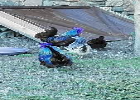

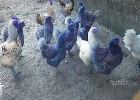

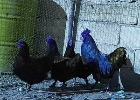

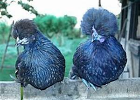

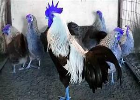

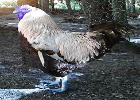

Number of resized images: 1815
Category: sheep
Number of outliers: 83
Showing outlier images:


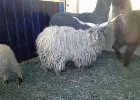

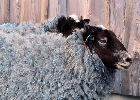

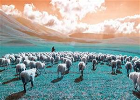

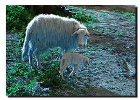

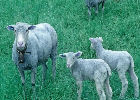

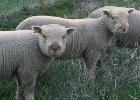

Number of resized images: 1842
Category: squirrel
Number of outliers: 8
Showing outlier images:


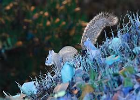

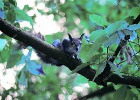

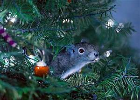

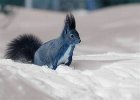

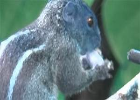

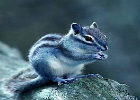

Number of resized images: 2613
Category: horse
Number of outliers: 61
Showing outlier images:


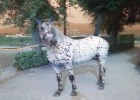

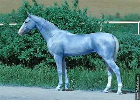

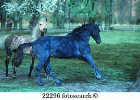

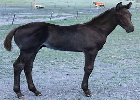

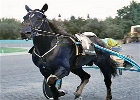

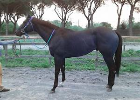

Number of resized images: 1616
Category: cat
Number of outliers: 4
Showing outlier images:


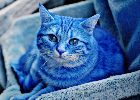

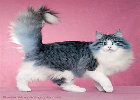

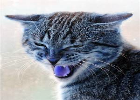

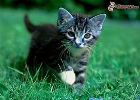

Number of resized images: 1864
Category: cow
Number of outliers: 75
Showing outlier images:


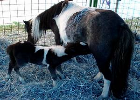

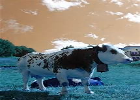

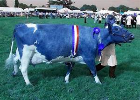

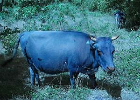

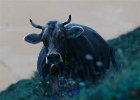

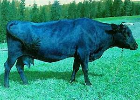

Number of resized images: 4758
Category: dog
Number of outliers: 12
Showing outlier images:


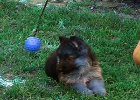

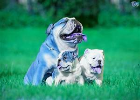

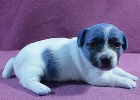

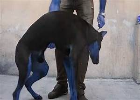

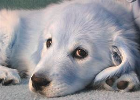

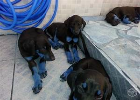

Number of resized images: 1432
Category: elephant
Number of outliers: 74
Showing outlier images:


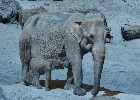

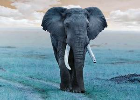

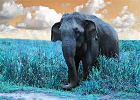

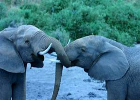

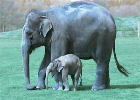

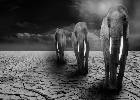

Number of resized images: 2065
Category: butterfly
Number of outliers: 1
Showing outlier images:


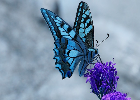

Number of resized images: 4693
Category: spider
Number of outliers: 32
Showing outlier images:


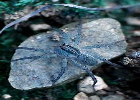

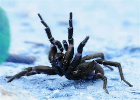

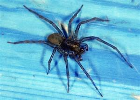

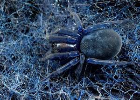

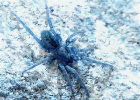

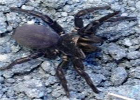

In [ ]:
images=[]
path_to_dataset = path + training_folder
#to_be_deleted_folder = os.path.join(path_to_dataset, 'to_be_deleted')
m=0
# create the 'images_to_be_deleted' folder if it doesn't exist
'''if not os.path.exists(to_be_deleted_folder):
    os.makedirs(to_be_deleted_folder)'''

# loop through each category folder
for folder in os.listdir(path_to_dataset):
    # create an empty list to store the file names
    file_names = []
    # loop through each file in the folder
    for file in os.listdir(os.path.join(path_to_dataset, folder)):
        # check if the file is a JPEG image and load it
        if file.endswith(".jpg") or file.endswith(".jpeg"):
            file_names.append(file)
        
    for file_name in file_names:
        img = cv2.imread(os.path.join(path_to_dataset, folder, file_name))
        if img is None:
            m=m+1
            #print(f"Could not load image {file_name}")
        images.append(img)
    #print(f"Loaded {len(images)} images")

    # load all the images, resize them to a common size, and stack them horizontally
    height = 100
    width = 140
    images = [cv2.imread(os.path.join(path_to_dataset, folder, file_name)) for file_name in file_names]
    images_resized = [cv2.resize(img, (width, height)) for img in images if img is not None]
    print(f"Number of resized images: {len(images_resized)}")
    images_stacked = np.hstack(images_resized)
    
    # calculate the mean and standard deviation of the pixel values for each channel
    channel_means = np.mean(images_stacked, axis=(0))
    channel_stdevs = np.std(images_stacked, axis=(0,1)) + 1e-9
    
    # calculate the Z-scores for each pixel in each channel
    z_scores = (images_stacked - channel_means) / channel_stdevs
    
    # calculate the mean Z-score for each image
    mean_z_scores = np.mean(z_scores.reshape(z_scores.shape[0], -1), axis=1)
    
    # find the outliers based on a threshold (e.g., 3 standard deviations)
    threshold = 0.1
    outliers = np.where(np.abs(mean_z_scores) > threshold)[0]
    
    print(f"Category: {folder}")
    print(f"Number of outliers: {len(outliers)}")
    #print(f"Outlier indices: {outliers}")

    # show 5 outlier images at random without repetition
    if len(outliers) > 0:
        num_to_show = min(len(outliers), 6)
        outlier_indices = random.sample(range(len(outliers)), num_to_show)
        print("Showing outlier images:")
        for idx in outlier_indices:
            outlier_image = images_resized[outliers[idx]]
            outlier_image = Image.fromarray(outlier_image.astype(np.uint8))
            outlier_image.show()
    
    # delete the outlier images
    for idx in outliers:
        image_path = os.path.join(path_to_dataset, folder, file_names[idx])
        if os.path.exists(image_path):
            try:
                os.remove(image_path)
            except:
                m=m+1
                #print(f"Error deleting {file_names[idx]}")
    


There are not too many outliers and the images are right to be called outliers, so the outliers are removed.

# **Split**

To do the train/test split the group decided that in the test folder it should be the same number of instances of each class, and since the dataset is unbalanced, keep in mind that the spider and dog folders have around 5000 instances and there others with less than 2000 images. So the split would be based on the number of instances of the class with the least number of files in it. 
The test folder will have 15% of the images of the category with the least categpries. 15% was decided since the group thought it important to have as much information as possible to train the cnn due to the high variability of the dataset, while also having enough test images to make it representative.

Bar Graph of the present dimensions of the folders.

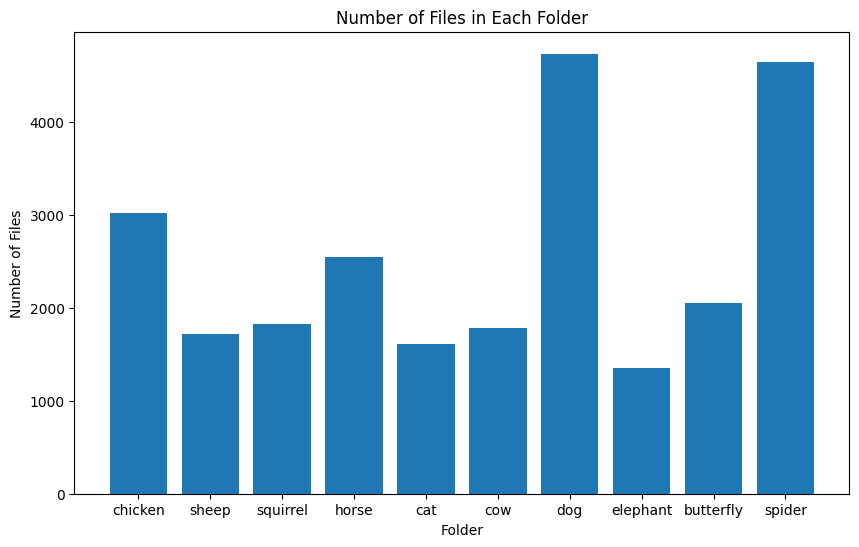

In [ ]:
# set the path to the folder containing the subfolders
path_to_folder = path + training_folder

# create an empty list to store the number of files in each folder
num_files = []
count=0
# loop through each folder in the directory
for folder in os.listdir(path_to_folder):
    # get the path to the folder
    folder_path = os.path.join(path_to_folder, folder)
    # count the number of files in the folder
    num_files_in_folder = len(os.listdir(folder_path))
    # append the number of files to the list
    num_files.append(num_files_in_folder)
    count=count + num_files_in_folder
# create a bar chart of the number of files in each folder
plt.figure(figsize=(10, 6))
plt.bar(range(len(num_files)), num_files)
plt.xticks(range(len(num_files)), os.listdir(path_to_folder))
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Folder')
plt.show()


The initial number of images in the dataset is 26179, and now the dataset has 25300 images. The percentage of deleted images is 3%, which is an okay percentage to delete.

Permenantly resize images in the dataset to the right size (140, 100).

In [ ]:

# loop through each category folder
for folder in os.listdir(os.path.join(path, training_folder)):
    # create an empty list to store the file names
    file_names = []
    # loop through each file in the folder
    for file in os.listdir(os.path.join(path, training_folder, folder)):
        # check if the file is a JPEG image and load it
        if file.endswith(".jpg") or file.endswith(".jpeg"):
            file_names.append(file)
        
    for file_name in file_names:
        img_path = os.path.join(path, training_folder, folder, file_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not load image {file_name}")
        else:
            # resize the image and save it back to disk
            resized_img = cv2.resize(img, (140, 100))
            cv2.imwrite(img_path, resized_img)


The purpose of this code is to create a test dataset for evaluating the performance of a machine learning model trained on the images in the "train" folder. The test dataset is created by randomly selecting a fixed number of images (350 in this case) from each category folder and moving them to the "test" folder, thereby creating a balanced test dataset with an equal number of images from each category. This allows for evaluating the model's performance on unseen data during model testing and validation. The shutil module is used to move the image files from the "train" folder to the "test" folder.

In [ ]:
# set the path to the parent folder containing the category folders
parent_folder = path 

# create a new folder called "test"
test_folder = os.path.join(parent_folder, 'test')
os.mkdir(test_folder)

# loop through each category folder in the train folder
for category_folder in os.listdir(os.path.join(parent_folder, 'train')):
    # create a new subfolder with the same name in the test folder
    os.mkdir(os.path.join(test_folder, category_folder))

    # get a list of all the image files in the current category folder
    image_files = [os.path.join(parent_folder, 'train', category_folder, f) for f in os.listdir(os.path.join(parent_folder, 'train', category_folder)) if f.endswith('.jpg') or f.endswith('.jpeg')]

    # randomly select 350 image files from the list
    selected_image_files = random.sample(image_files, 350)

    # move each selected image file to the corresponding subfolder in the test folder
    for image_file in selected_image_files:
        shutil.move(image_file, os.path.join(test_folder, category_folder))


Bar graph of the sizes of the images in the the testing folders.

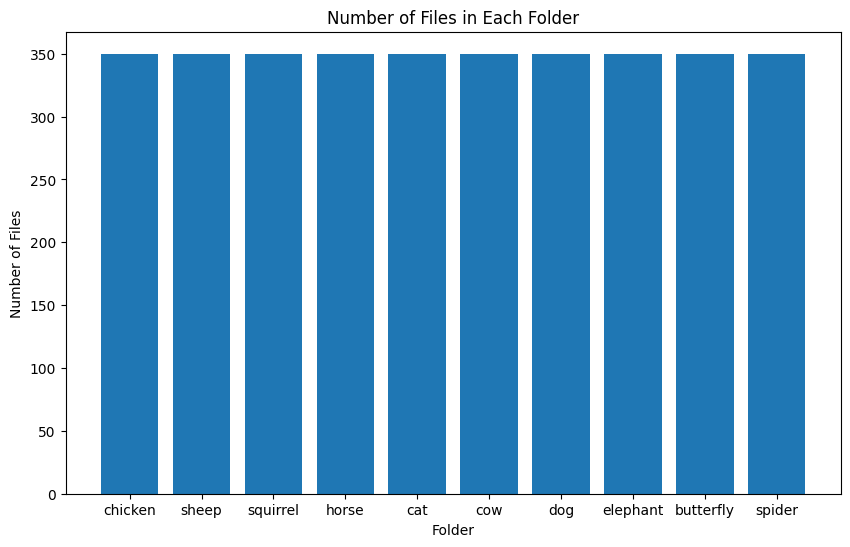

In [ ]:

# set the path to the folder containing the subfolders
path_to_folder = os.path.join(path, 'test')

# create an empty list to store the number of files in each folder
num_files = []

# loop through each folder in the directory
for folder in os.listdir(path_to_folder):
    # get the path to the folder
    folder_path = os.path.join(path_to_folder, folder)
    # count the number of files in the folder
    num_files_in_folder = len(os.listdir(folder_path))
    # append the number of files to the list
    num_files.append(num_files_in_folder)

# create a bar chart of the number of files in each folder
plt.figure(figsize=(10, 6))
plt.bar(range(len(num_files)), num_files)
plt.xticks(range(len(num_files)), os.listdir(path_to_folder))
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Number of Files in Each Folder')
plt.show()


# **Data Processing & Augmentation**

Ir order to decide the parameters of the augmentation, the code from the classes to see the effects on the images and decide the paremeters to use.

After, data augmentation will be performed on the categories with less images than the largest in order to balance the dataset. Data augmentation will not be use on the largest category as, due to the high variabilty of the dataset it was deemed not needed. The folders with the least images use augmentation will have a little more than 2 new images created from the same one, which the group found reasonable, and an interesting factor to see the effect on the model's permoance for each category.

In [ ]:
image_size=(140, 100)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory(path + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Using 5235 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 140, 100, 3) (64, 10)

Sample of x_train: tf.Tensor(
[[174.28143 169.42857]
 [173.13214 172.28572]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(5, 10), dtype=float32)
Sample average of y_train: tf.Tensor(0.1, shape=(), dtype=float32)


In [ ]:
augmentation = Sequential([
    layers.RandomRotation(factor=0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomContrast(factor=0.3),
    layers.RandomBrightness(factor=0.3),
], name='image_augmentation')


Visualize and decide on the parameters:

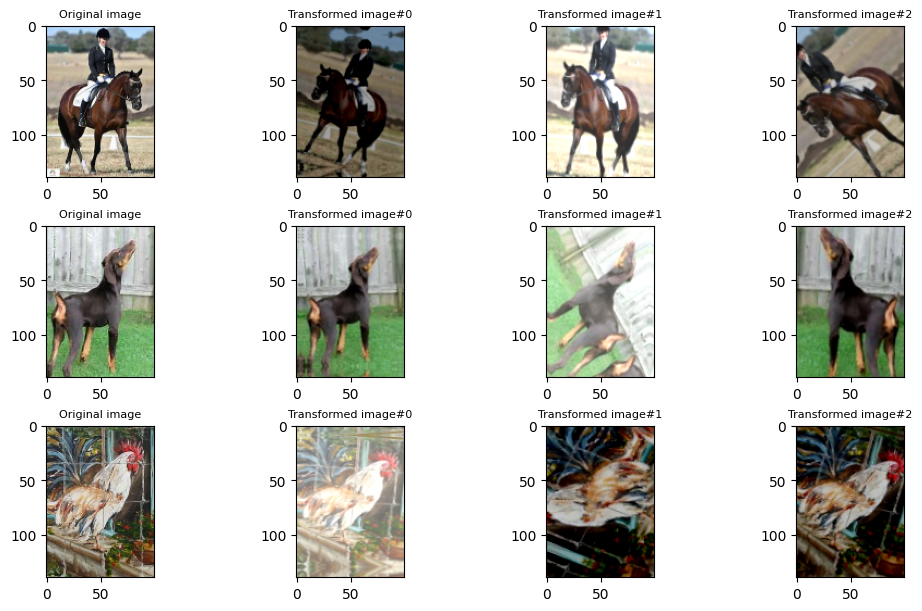

In [ ]:
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=3, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training=True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

show_augmented_sample_batch(batch_x_train[8:11], augmentation_pipe=augmentation)

### **Data Augmentation**

Code:
Creating the CNN model: The code defines a convolutional neural network (CNN) model using the Sequential API from Keras. The model consists of several Conv2D (2-dimensional convolutional) layers with ReLU activation, MaxPooling2D (2-dimensional max pooling) layers, and Dense (fully connected) layers with ReLU and softmax activations for the output layer. The input shape of the model is set to (140, 100, 3) which corresponds to images with height of 140 pixels, width of 100 pixels, and 3 channels (RGB).

Compiling the model: The model is compiled using the 'adam' optimizer, 'categorical_crossentropy' loss function for multi-class classification, and 'accuracy' as the evaluation metric.

Data preparation: The code defines input and output directories for the training data, and retrieves the list of classes from the input directory. It also calculates the maximum number of images in a class to later balance the dataset.

Balancing the dataset: The code checks each class and if the number of images in a class is less than the maximum number of images across all classes, it duplicates images in that class to balance the dataset. The duplicated images are saved with a prefix of the index (i.e., 0, 1, 2, etc.) to avoid overwriting existing images.

Data augmentation: The code uses the ImageDataGenerator class from Keras to perform data augmentation. Various augmentation techniques such as rotation, width shift, height shift, shear, zoom, and horizontal flip are applied to the images to create additional training samples and increase the diversity of the dataset.

Creating a data generator: The flow_from_directory() method of the ImageDataGenerator class is used to generate batches of augmented images on-the-fly from the balanced dataset. The output directory (where the balanced dataset is saved), target size, color mode, batch size, class mode, and other parameters are specified.

Training the model: The model is trained using the fit() method with the data generator as the input. The number of steps per epoch is calculated as the total number of samples divided by the batch size. The number of epochs is set to 4 in this example, but it can be adjusted based on the specific requirements of the task and model.

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(140, 100, 3)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')  # change 10 to the number of classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
input_dir = path + training_folder
output_dir = path + training_folder

classes = os.listdir(input_dir)

# Find the maximum number of images in a class
max_count = 0
for c in classes:
    count = len(os.listdir(os.path.join(input_dir, c)))
    if count > max_count:
        max_count = count

        

# Balance the dataset by copying images to underrepresented classes
for c in classes:
    src_dir = os.path.join(input_dir, c)
    dst_dir = os.path.join(output_dir, c)
    os.makedirs(dst_dir, exist_ok=True)

    file_names = os.listdir(src_dir)
    count = len(file_names)
    if count < max_count:
        for i in range(max_count - count):
            file_name = random.choice(file_names)
            src_path = os.path.join(src_dir, file_name)
            dst_path = os.path.join(dst_dir, f'{i}_{file_name}')

            # Convert the image to JPEG format
            im = Image.open(src_path)
            rgb_im = im.convert('RGB')
            rgb_im.save(dst_path, quality=95)

# Data augmentation using flow_from_directory
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    directory=output_dir,
    target_size=(140, 100),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=4
)


Found 43860 images belonging to 10 classes.
Epoch 1/4
1370/1370 [==============================] - 165s 111ms/step - loss: 2.6416 - accuracy: 0.1726
Epoch 2/4
1370/1370 [==============================] - 150s 110ms/step - loss: 1.9343 - accuracy: 0.3110
Epoch 3/4
1370/1370 [==============================] - 150s 109ms/step - loss: 1.7538 - accuracy: 0.3832
Epoch 4/4
1370/1370 [==============================] - 151s 110ms/step - loss: 1.6191 - accuracy: 0.4284


Check the sizes of the folder to make sure the dataset is now balanced.

In [ ]:
for split in [training_folder]:
    for c in ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']:
        n_train_c = len(os.listdir(path  + split + f"/{c}"))
        print(f"{split}: {n_train_c} instances of class {c}")

train: 4386 instances of class butterfly
train: 4386 instances of class cat
train: 4386 instances of class chicken
train: 4386 instances of class cow
train: 4386 instances of class dog
train: 4386 instances of class elephant
train: 4386 instances of class horse
train: 4386 instances of class sheep
train: 4386 instances of class spider
train: 4386 instances of class squirrel


**Final Dataset Description**

- train with 43860 instances, 4386 in each class
- test with 3500 instances, 350 in each folder.

## **Download**

The 2 folders (train and test) will be zipped and downloaded to the local machine from google collab and then uploaded to the google drive to be used in the cnn's.

In [ ]:
!zip -r /content/train.zip /content/train

Streaming output truncated to the last 5000 lines.
  adding: content/train/butterfly/OIP-sh2RFLL1BfLEvu83MAKtwgHaE1.jpeg (deflated 4%)
  adding: content/train/butterfly/1264_OIP-qHDxLOMNKuCHV8wtsOrE-QHaFa.jpeg (deflated 3%)
  adding: content/train/butterfly/483_OIP-FeW2EO3cmqGWyexuqscGQgHaFj.jpeg (deflated 2%)
  adding: content/train/butterfly/266_OIP-7yn3DKg0ioOlfiFo_lkdvwHaH6.jpeg (deflated 2%)
  adding: content/train/butterfly/11_OIP-7csbSDZu-smxbz6uHhgFlgHaLD.jpeg (deflated 2%)
  adding: content/train/butterfly/1888_ee36b10b2bf41c22d2524518b7444f92e37fe5d404b0144390f8c770a2e9b5_640.jpg (deflated 2%)
  adding: content/train/butterfly/1425_OIP-Hizj5B9SZE1NMH30QUEuYAHaFb.jpeg (deflated 2%)
  adding: content/train/butterfly/605_OIP-xbHvqxV9bvly5jPWJ7M_hwHaHa.jpeg (deflated 2%)
  adding: content/train/butterfly/ea36b4092df7073ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg (deflated 1%)
  adding: content/train/butterfly/OIP-fFvTkX3z7AXrK8pXBForNQHaEo.jpeg (deflated 2%)
  addin

In [ ]:
files.download("/content/train.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/test.zip /content/test

  adding: content/test/ (stored 0%)
  adding: content/test/chicken/ (stored 0%)
  adding: content/test/chicken/OIP-QmQoHPxm2qRPiQ2Pi39aegHaE8.jpeg (deflated 2%)
  adding: content/test/chicken/OIP-HXvEqOxEvCwggG9s6ebmpQHaHa.jpeg (deflated 2%)
  adding: content/test/chicken/OIP-akyiuSFaK_xVArps4ld0PgHaFY.jpeg (deflated 1%)
  adding: content/test/chicken/480.jpeg (deflated 1%)
  adding: content/test/chicken/800.jpeg (deflated 1%)
  adding: content/test/chicken/OIP-fxcEtFUQp3RWD-CcdDoFaAAAAA.jpeg (deflated 2%)
  adding: content/test/chicken/OIP-u2p7bbpwNEJlffZGqjCREAHaFj.jpeg (deflated 1%)
  adding: content/test/chicken/OIP-jHdN9EC-z9I5mVTE3qi-oQHaDf.jpeg (deflated 1%)
  adding: content/test/chicken/OIP-WUO9_uC4tDQkxRFwfw4zVAHaFj.jpeg (deflated 1%)
  adding: content/test/chicken/OIP-iho_bhEH2besixZq6MYDBgHaLG.jpeg (deflated 1%)
  adding: content/test/chicken/OIP-glILls1wy2Apj1kO5s1fWwHaFj.jpeg (deflated 2%)
  adding: content/test/chicken/613.jpeg (deflated 1%)
  adding: content/test/chicke

In [ ]:
files.download("/content/test.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>